In [ ]:
!pip install conllu seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=0c701dc59439b21760246a5bd76ddf68b10cf3845649ef27dc014b5c1bfcdbc0
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from conllu import parse_incr
from pathlib import Path

def read_conllu(file_path):
    sentences, tags = [], []
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence, pos_tags = [], []
            for token in tokenlist:
                if isinstance(token['form'], str):
                    sentence.append(token['form'])
                    pos_tags.append(token['upostag'])
            sentences.append(sentence)
            tags.append(pos_tags)
    return sentences, tags

# Example usage
train_sentences, train_tags = read_conllu("en_ewt-ud-train.conllu")
dev_sentences, dev_tags = read_conllu("en_ewt-ud-dev.conllu")
test_sentences, test_tags = read_conllu("en_ewt-ud-test.conllu")


In [ ]:
from collections import defaultdict
import torch

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

def build_vocab(sentences, tags):
    word_freq = defaultdict(int)
    tag_set = set()

    for sent, tag_seq in zip(sentences, tags):
        for word, tag in zip(sent, tag_seq):
            word_freq[word.lower()] += 1
            tag_set.add(tag)

    word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word in word_freq:
        word2idx[word] = len(word2idx)

    tag2idx = {PAD_TOKEN: 0}
    for tag in sorted(tag_set):
        tag2idx[tag] = len(tag2idx)

    idx2tag = {i: t for t, i in tag2idx.items()}
    return word2idx, tag2idx, idx2tag

def encode(sentences, tags, word2idx, tag2idx, max_len=128):
    encoded_sents, encoded_tags = [], []
    for sent, tag_seq in zip(sentences, tags):
        word_ids = [word2idx.get(word.lower(), word2idx[UNK_TOKEN]) for word in sent]
        tag_ids = [tag2idx[tag] for tag in tag_seq]

        # Padding
        word_ids = word_ids[:max_len] + [word2idx[PAD_TOKEN]] * (max_len - len(word_ids))
        tag_ids = tag_ids[:max_len] + [tag2idx[PAD_TOKEN]] * (max_len - len(tag_ids))

        encoded_sents.append(word_ids)
        encoded_tags.append(tag_ids)

    return torch.tensor(encoded_sents), torch.tensor(encoded_tags)


In [ ]:
word2idx, tag2idx, idx2tag = build_vocab(train_sentences, train_tags)

X_train, y_train = encode(train_sentences, train_tags, word2idx, tag2idx)
X_dev, y_dev = encode(dev_sentences, dev_tags, word2idx, tag2idx)
X_test, y_test = encode(test_sentences, test_tags, word2idx, tag2idx)


In [ ]:
!pip install pytorch-crf

In [ ]:
import torch
import torch.nn as nn
from torchcrf import CRF  # install with: pip install pytorch-crf

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=256, pad_idx=0):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.hidden2tag(lstm_out)

        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)


In [ ]:
def create_mask(x, pad_idx=0):
    return x != pad_idx


In [ ]:
def train_model(model, X_train, y_train, optimizer, tag_pad_idx, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(X_train)):
            x = X_train[i].unsqueeze(0)
            y = y_train[i].unsqueeze(0)
            mask = create_mask(x, pad_idx=0)

            optimizer.zero_grad()
            loss = model(x, y, mask=mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")


In [ ]:
vocab_size = len(word2idx)
tagset_size = len(tag2idx)
pad_idx = word2idx["<PAD>"]

model = BiLSTM_CRF(vocab_size, tagset_size, pad_idx=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch.nn.functional as F

def kl_divergence_with_logit(p_logit, q_logit):
    p = F.softmax(p_logit, dim=-1)
    log_p = F.log_softmax(p_logit, dim=-1)
    log_q = F.log_softmax(q_logit, dim=-1)
    return torch.sum(p * (log_p - log_q), dim=-1).mean()


In [ ]:
def compute_vat_loss(model, x, mask, xi=1e-6, epsilon=3.5, num_power_iter=1):
    model.eval()
    x = x.unsqueeze(0)
    mask = mask.unsqueeze(0)

    with torch.no_grad():
        embeds = model.embedding(x)
        lstm_out, _ = model.lstm(embeds)
        orig_output = model.hidden2tag(lstm_out)

    d = torch.randn_like(embeds)
    for _ in range(num_power_iter):
        d = xi * F.normalize(d, p=2, dim=-1)
        d.requires_grad_()
        perturbed_embeds = embeds + d
        lstm_out_perturbed, _ = model.lstm(perturbed_embeds)
        perturbed_output = model.hidden2tag(lstm_out_perturbed)
        loss_kl = kl_divergence_with_logit(orig_output.detach(), perturbed_output)
        grad, = torch.autograd.grad(loss_kl, [d], retain_graph=False)
        d = grad.detach()

    d = epsilon * F.normalize(d, p=2, dim=-1)
    perturbed_embeds = embeds + d
    lstm_out_perturbed, _ = model.lstm(perturbed_embeds)
    perturbed_output = model.hidden2tag(lstm_out_perturbed)

    vat_loss = kl_divergence_with_logit(orig_output.detach(), perturbed_output)
    model.train()
    return vat_loss


In [ ]:
def train_model_vat(model, X_train, y_train, optimizer, tag_pad_idx, alpha=1.0, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(X_train)):
            x = X_train[i]
            y = y_train[i]
            mask = create_mask(x, pad_idx=0)

            optimizer.zero_grad()
            crf_loss = model(x.unsqueeze(0), y.unsqueeze(0), mask=mask.unsqueeze(0))
            vat_loss = compute_vat_loss(model, x, mask)
            loss = crf_loss + alpha * vat_loss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")


In [ ]:
train_model_vat(model, X_train, y_train, optimizer, tag_pad_idx=tag2idx["<PAD>"], alpha=0.5, epochs=5)


Epoch 1, Loss: 90279.7352
Epoch 2, Loss: 37909.6162
Epoch 3, Loss: 19213.4517
Epoch 4, Loss: 9782.7441
Epoch 5, Loss: 6082.7846


In [ ]:
from sklearn.metrics import classification_report

# Flatten true and predicted labels, excluding padding tokens
y_true_flat = [tag for sent in y_true for tag in sent if tag != tag2idx["<PAD>"]]
y_pred_flat = [tag for sent in y_pred for tag in sent if tag != tag2idx["<PAD>"]]

# Extract all unique tags from true and predicted labels
unique_tags = set(y_true_flat + y_pred_flat)

# Exclude <PAD> tag
unique_tags.discard(tag2idx["<PAD>"])

# Create a list of tag names corresponding to the unique tags
target_names = [idx2tag[idx] for idx in unique_tags]

# Generate classification report with labels explicitly set
print(classification_report(y_true_flat, y_pred_flat, target_names=target_names))


              precision    recall  f1-score   support

         ADJ       0.90      0.84      0.87      1794
         ADP       0.95      0.95      0.95      2030
         ADV       0.89      0.90      0.89      1183
         AUX       0.98      0.98      0.98      1543
       CCONJ       1.00      0.99      0.99       736
         DET       0.99      0.99      0.99      1896
        INTJ       0.84      0.80      0.82       121
        NOUN       0.83      0.88      0.86      4123
         NUM       0.93      0.64      0.76       542
        PART       0.95      0.98      0.96       649
        PRON       0.98      0.99      0.98      2166
       PROPN       0.71      0.74      0.72      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.87      0.80      0.83       384
         SYM       0.86      0.82      0.84       109
        VERB       0.90      0.91      0.91      2606
           X       0.13      0.05      0.07        42
           _       0.99    

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def flatten_labels(model, X, y, idx2tag, tag_pad_idx=0):
    model.eval()
    true_tags_flat = []
    pred_tags_flat = []

    with torch.no_grad():
        for i in range(len(X)):
            x = X[i].unsqueeze(0)
            y_true = y[i]
            mask = create_mask(x, pad_idx=tag_pad_idx)

            y_pred = model(x, mask=mask)[0]  # list of ints

            true_tags = [idx2tag[tag.item()] for tag, m in zip(y_true, mask[0]) if m]
            pred_tags = [idx2tag[tag] for tag in y_pred]

            true_tags_flat.extend(true_tags)
            pred_tags_flat.extend(pred_tags)

    return true_tags_flat, pred_tags_flat


In [ ]:
def plot_confusion(true_tags, pred_tags, labels):
    cm = confusion_matrix(true_tags, pred_tags, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
    plt.title("POS Tag Confusion Matrix")
    plt.show()


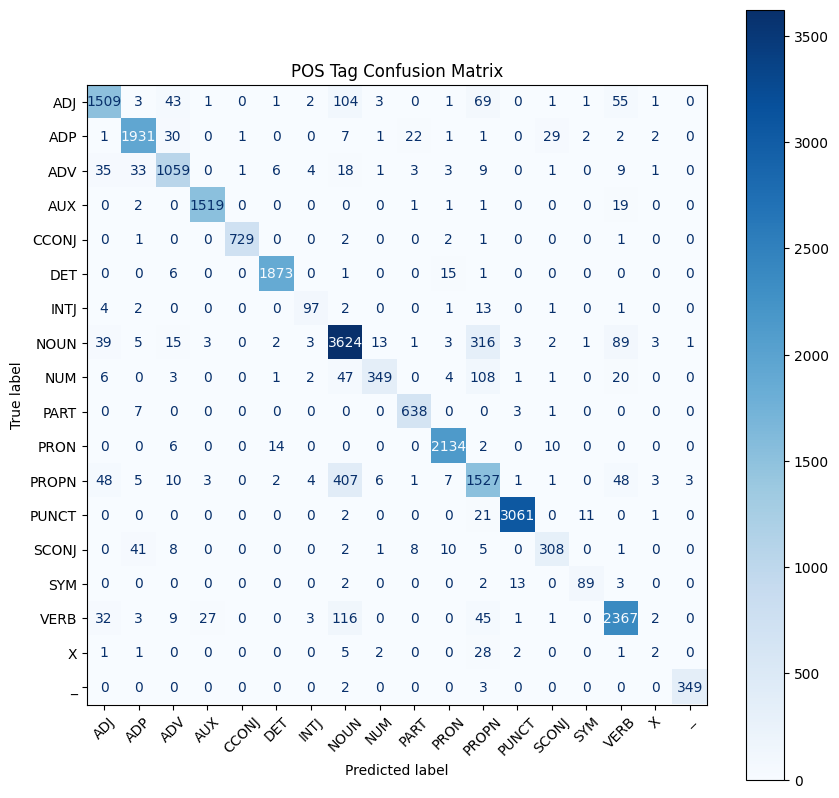

In [ ]:
true_flat, pred_flat = flatten_labels(model, X_test, y_test, idx2tag, tag_pad_idx=tag2idx["<PAD>"])
labels = list(tag2idx.keys())
labels.remove("<PAD>")  # remove pad tag from display
plot_confusion(true_flat, pred_flat, labels)


In [ ]:
!pip install transformers conllu seqeval scikit-learn pytorch-crf


In [ ]:
from conllu import parse_incr

def read_conllu(file_path):
    sentences, tags = [], []
    with open(file_path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sentence, pos_tags = [], []
            for token in tokenlist:
                if isinstance(token['form'], str):
                    sentence.append(token['form'])
                    pos_tags.append(token['upostag'])
            sentences.append(sentence)
            tags.append(pos_tags)
    return sentences, tags

# Upload .conllu files first
train_sentences, train_tags = read_conllu("/content/en_ewt-ud-train.conllu")
val_sentences, val_tags = read_conllu("/content/en_ewt-ud-dev.conllu")
test_sentences, test_tags = read_conllu("/content/en_ewt-ud-test.conllu")


In [ ]:
def build_tag_map(tags):
    tag_set = sorted({tag for seq in tags for tag in seq})
    tag_set.append("<PAD>")
    tag2idx = {tag: i for i, tag in enumerate(tag_set)}
    idx2tag = {i: tag for tag, i in tag2idx.items()}
    return tag2idx, idx2tag

tag2idx, idx2tag = build_tag_map(train_tags)


In [ ]:
from transformers import BertTokenizerFast
import torch

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

def tokenize_and_align(sentences, tags, tag2idx):
    encoded = tokenizer(sentences,
                        is_split_into_words=True,
                        return_offsets_mapping=True,
                        padding=True,
                        truncation=True,
                        return_tensors="pt")
    labels = []
    for i, label in enumerate(tags):
        word_ids = encoded.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(tag2idx["<PAD>"])
            elif word_idx != previous_word_idx:
                label_ids.append(tag2idx[label[word_idx]])
            else:
                label_ids.append(tag2idx["<PAD>"])
            previous_word_idx = word_idx
        labels.append(label_ids)
    encoded["labels"] = torch.tensor(labels)
    return encoded

train_data = tokenize_and_align(train_sentences[:1000], train_tags[:1000], tag2idx)  # slice for speed
val_data = tokenize_and_align(val_sentences, val_tags, tag2idx)
test_data = tokenize_and_align(test_sentences, test_tags, tag2idx)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch.nn as nn
from torchcrf import CRF
from transformers import BertModel

class BERT_CRF_VAT(nn.Module):
    def __init__(self, tagset_size):
        super(BERT_CRF_VAT, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.hidden2tag = nn.Linear(self.bert.config.hidden_size, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        emissions = self.hidden2tag(outputs.last_hidden_state)
        mask = attention_mask.bool()

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)


In [ ]:
import torch.nn.functional as F

def vat_loss(model, input_ids, attention_mask, xi=1e-6, eps=2.0):
    model.eval()
    embeds = model.bert.embeddings(input_ids)
    embeds.requires_grad_()

    with torch.enable_grad():
        outputs = model.bert(inputs_embeds=embeds, attention_mask=attention_mask)
        logits = model.hidden2tag(outputs.last_hidden_state).detach()
        soft = F.softmax(logits, dim=-1)

        d = torch.randn_like(embeds)
        d = xi * F.normalize(d, p=2, dim=-1)
        perturbed = embeds + d

        perturbed_out = model.bert(inputs_embeds=perturbed, attention_mask=attention_mask)
        perturbed_logits = model.hidden2tag(perturbed_out.last_hidden_state)
        perturbed_soft = F.log_softmax(perturbed_logits, dim=-1)

        return F.kl_div(perturbed_soft, soft, reduction="batchmean")


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_CRF_VAT(len(tag2idx)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_dataset = TensorDataset(train_data["input_ids"], train_data["attention_mask"], train_data["labels"])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # use smaller batch for stability

for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels)
        try:
            adv_loss = vat_loss(model, input_ids, attention_mask)
            total = loss + 0.5 * adv_loss
        except Exception as e:
            print("VAT failed, using only CRF loss")
            total = loss
        total.backward()
        optimizer.step()
        total_loss += total.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 4452.0421
Epoch 2: Loss = 479.7313
Epoch 3: Loss = 144.5396


In [ ]:
from seqeval.metrics import classification_report

def evaluate(model, data, idx2tag):
    model.eval()
    preds, labels = [], []
    for i in range(len(data["input_ids"])):
        input_ids = data["input_ids"][i].unsqueeze(0).to(device)
        attention_mask = data["attention_mask"][i].unsqueeze(0).to(device)
        label_ids = data["labels"][i]
        pred_ids = model(input_ids, attention_mask)[0]
        true = [idx2tag[l.item()] for l, p in zip(label_ids, pred_ids) if l.item() != tag2idx["<PAD>"]]
        pred = [idx2tag[p] for l, p in zip(label_ids, pred_ids) if l.item() != tag2idx["<PAD>"]]
        labels.append(true)
        preds.append(pred)
    print(classification_report(labels, preds))

evaluate(model, test_data, idx2tag)


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PRON seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: SCONJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROPN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:17

              precision    recall  f1-score   support

         ART       0.98      0.98      0.98       645
        CONJ       0.96      0.98      0.97      1108
          DJ       0.91      0.89      0.90      1699
          DP       0.97      0.96      0.96      1969
          DV       0.86      0.90      0.88      1085
         ERB       0.97      0.96      0.97      2570
          ET       0.99      0.99      0.99      1873
         NTJ       0.66      0.67      0.67       118
         OUN       0.88      0.91      0.89      3564
        PAD>       0.00      0.00      0.00         0
         RON       0.99      0.99      0.99      2126
        ROPN       0.82      0.78      0.80      1570
          UM       0.93      0.91      0.92       500
        UNCT       0.98      0.98      0.98      2967
          UX       0.97      0.99      0.98      1422
          YM       0.77      0.18      0.30       109
           _       0.92      0.86      0.89       368

   micro avg       0.93   